In [1]:
import bayesflow as bf
import keras
import matplotlib.pyplot as plt
import numpy as np

# reduce image resolution to reduce file size
plt.rcParams["figure.dpi"] = 80

2025-07-22 08:56:37.467070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753174597.525001   68310 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753174597.542334   68310 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 08:56:37.703546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 08:56:41.618056: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

# Inference on Spatial Data: Gaussian Random Fields

*Author:  Valentin Pratz*

In this tutorial, we demonstrate how to use BayesFlow on spatial data.
This is straight-forward, and the main challenge is building a suitable summary network.
Here, we will focus on the simple case where the data is available on a grid.
In that case, we can leverage common architectures used in image processing.

As a toy example, we will take a look at Gaussian random fields (GRFs).
For a nice introduction that also serves as the inspiration for the example below, refer to the article [The Beauty of Gaussian Random Fields](https://structures.uni-heidelberg.de/blog/posts/gaussian-random-fields/index.php) ([archive](https://web.archive.org/web/20250323141017/https://structures.uni-heidelberg.de/blog/posts/gaussian-random-fields/index.php)) by Sara Konrad. Below, we give a short summary that should be sufficient to get the gist of the example.

GRFs describe spatially correlated variables.
For homogeneous and isotropic GRFs, the underlying covariance function does not depend on the position and only depends on the distance, not on the direction.
In that case, the GRF can be completely described by a mean value, which can be set to zero without loss of generality, and the covariance function.
The covariance function can be translated into frequency space using the Fourier transform, giving the *power spectrum* of the covariance function.
This describes the amount of correlation as a function of the wave number $k$.
An interesting example is the power law power spectrum $P(k)=k^{-\alpha}$.
It shows the same behavior on different scales, leading to fractal structures.
The exact behavior is defined by the exponent $\alpha$, which we want to estimate, along with a scaling factor describing the magnitude of the field.

For the simulations, we will use the [FyeldGenerator](https://github.com/cphyc/FyeldGenerator) package ([Zenodo](https://zenodo.org/record/7427712)).

In [2]:
!pip install FyeldGenerator==0.1.7

The package provides us with the `generate_field` function, which requires a distribution to sample complex values (usually from a standard normal distribution for both real and imaginary part), a power spectrum and the shape of the desired grid. Let's define them and take a look at some examples:

In [3]:
from FyeldGenerator import generate_field

In [4]:
def generate_power_spectrum(alpha, scale):
    def power_spectrum(k):
        return np.power(k, -alpha) * scale**2

    return power_spectrum


def distribution(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

In [5]:
shape = (64, 64)
power_spectrum = generate_power_spectrum(3.0, 1.0)

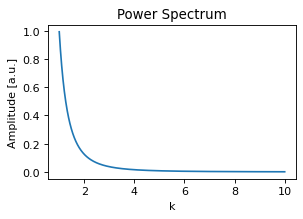

In [6]:
plt.figure(figsize=(4,2.5))
k = np.logspace(0.001, 1, 300)
plt.plot(k, power_spectrum(k))
plt.title("Power Spectrum")
plt.xlabel("k")
plt.ylabel("Amplitude [a.u.]");

Generating a field is internally achieved by sampling random numbers, a few multiplications and a fast Fourier transform, so generating a field is very fast:

In [7]:
%%time
np.random.seed(2025)
field = generate_field(distribution, power_spectrum, shape)

CPU times: user 2.58 ms, sys: 901 μs, total: 3.48 ms
Wall time: 2.14 ms


Below, we take a look at the way the patterns change when we change $\alpha$.

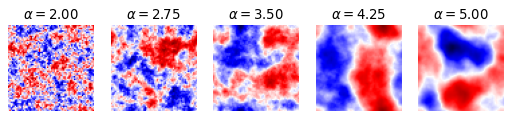

In [8]:
n_examples = 5
alphas = np.linspace(2, 5, n_examples)
fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 1.6, 1.7))
for alpha, ax in zip(alphas, axs):
    power_spectrum = generate_power_spectrum(alpha, 1)
    field = generate_field(distribution, power_spectrum, shape)
    max_magnitude = np.max(np.abs(field))
    ax.imshow(field, cmap="seismic", vmin=-max_magnitude, vmax=max_magnitude)
    ax.set_title(f"$\\alpha={alpha:.2f}$")
    ax.set_axis_off()

The difference is clearly visible, as the structures become more homogeneous as $\alpha$ increases.
The task is now for the summary network to learn relevant summary statistics from the images that enable the inference model to determine the correct parameter values.

## Summary Network

As we have translation-invariant images, [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network) are a natural choice as summary networks.
We currently provide the `ResNet` class in our experimental module, which implements a CNN architecture.
Each residual layer produces an output which divides the side length of the image by two.
The `widths` argument describes the number of *channels* the layer produces.
The `ResNet` does not handle to post-processing of the outputs, which consists of flattening and an additional dense layer, followed by a projection to the desired number of summary dimensions. In the class below, we inherit from `SummaryNetwork` and perform those steps, making the `ResNet` usable as a summary network.

In [9]:
import bayesflow.experimental.resnet


bf.utils.serialization.serializable("custom")


class ResNetSummaryNetwork(bf.networks.SummaryNetwork):
    def __init__(
        self,
        summary_dim,
        widths,
        num_fully_connected=64,
        dropout=0.0,
        use_batchnorm=False,
        **kwargs,
    ):
        """
        Create a ResNet summary network with a final dense layer.

        Parameters
        ----------
        summary_dim : int
            The dimension of the summary statistics.
        widths : Sequence of int
            The number of channels in the convolutional layers.
        num_fully_connected : int, optional
            The number of units in the fully connected layer (default is 64).
        dropout : float, optional
            Dropout probability in the residual layers (default is 0.0).
        use_batchnorm : bool, optional
            Use batch normalization in the residual layers (default is False).
        kwargs : dict, optional
            Additional keyword arguments for the tf.keras.Model superclass.
        """
        super().__init__(**kwargs)
        self.summary_dim = summary_dim

        layers = []
        layers.append(
            bf.experimental.resnet.ResNet(
                widths, use_batchnorm=use_batchnorm, dropout=dropout
            )
        )
        layers.append(keras.layers.Flatten())
        layers.append(keras.layers.Dense(num_fully_connected, activation="relu"))
        layers.append(keras.layers.Dense(summary_dim))

        self.net = bf.networks.Sequential(layers)

    def call(self, inputs, training: bool = False, **kwargs):
        return self.net(inputs)

## Simulator

We define a simple prior for the parameters and wrap the `generate_field` function to generate data in the desired structure.

In [10]:
rng = np.random.default_rng()


def prior():
    return {"log_std": rng.normal(), "alpha": rng.normal(loc=4, scale=0.5)}


def likelihood(log_std, alpha):
    field = generate_field(
        distribution, generate_power_spectrum(alpha, np.exp(log_std)), shape
    )

    return {"field": field[..., None]}


simulator = bf.make_simulator([prior, likelihood])

We can quickly check that the output shapes of the simulator match our expectations:

In [11]:
keras.tree.map_structure(keras.ops.shape, simulator.sample(3))

{'log_std': (3, 1), 'alpha': (3, 1), 'field': (3, 64, 64, 1)}

## Training

We will use online training, i.e., simulate the training data on the fly, but we already generate the validation data and test data:

In [12]:
%%time
validation_data = simulator.sample(100)

CPU times: user 45 ms, sys: 6.99 ms, total: 52 ms
Wall time: 51.7 ms


In [13]:
%%time
test_data = simulator.sample(1000)

CPU times: user 434 ms, sys: 57 ms, total: 491 ms
Wall time: 492 ms


We now create the summary network and the workflow object we use for training. Enabling dropout seems to cause problems during evaluation, so we disable it here.

In [14]:
summary_network = ResNetSummaryNetwork(
    summary_dim=6, widths=[8, 16, 32, 64, 128], num_fully_connected=128, dropout=0.0
)

workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    summary_network=summary_network,
    inference_variables=["log_std", "alpha"],
    summary_variables=["field"],
    standardize="all",
)

Now we are ready to start the online training. For detailed output during training, remove the `verbose=2` argument.
For better results, try to increase the number of epochs.
As we use convolutional layers, training can be quite slow on a CPU (10-15 minutes for 10 epochs), and using a GPU can significantly speed up training.

In [15]:
history = workflow.fit_online(
    num_batches_per_epoch=1000,
    validation_data=validation_data,
    batch_size=32,
    epochs=10,
    verbose=2,
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
1000/1000 - 74s - 74ms/step - loss: 2.1953 - val_loss: 1.1699
Epoch 2/10
1000/1000 - 61s - 61ms/step - loss: -1.7094e-01 - val_loss: -1.9486e-01
Epoch 3/10
1000/1000 - 62s - 62ms/step - loss: -6.8857e-01 - val_loss: -4.9103e-01
Epoch 4/10
1000/1000 - 62s - 62ms/step - loss: -9.7035e-01 - val_loss: -9.0175e-01
Epoch 5/10
1000/1000 - 62s - 62ms/step - loss: -1.2507e+00 - val_loss: -7.4549e-01
Epoch 6/10
1000/1000 - 61s - 61ms/step - loss: -1.4286e+00 - val_loss: -1.5773e+00
Epoch 7/10
1000/1000 - 62s - 62ms/step - loss: -1.5875e+00 - val_loss: -1.8030e+00
Epoch 8/10
1000/1000 - 63s - 63ms/step - loss: -1.8026e+00 - val_loss: -1.8770e+00
Epoch 9/10
1000/1000 - 60s - 60ms/step - loss: -1.9533e+00 - val_loss: -2.0199e+00
Epoch 10/10
1000/1000 - 60s - 60ms/step - loss: -2.0361e+00 - val_loss: -2.0326e+00


## Evaluation

Finally, we can plot the diagnostics. They show good recovery and calibration, indicating successful training.

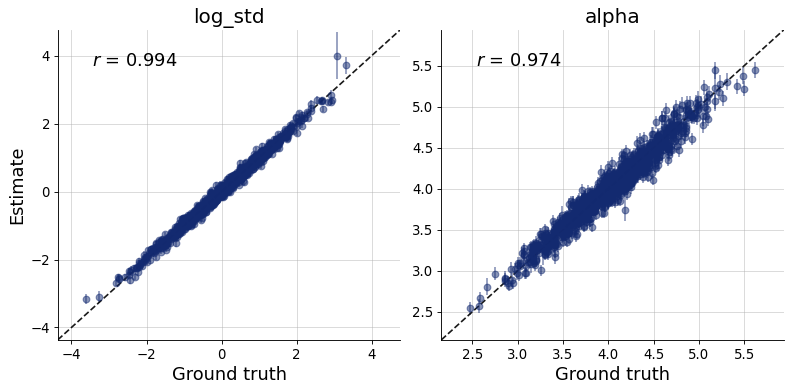

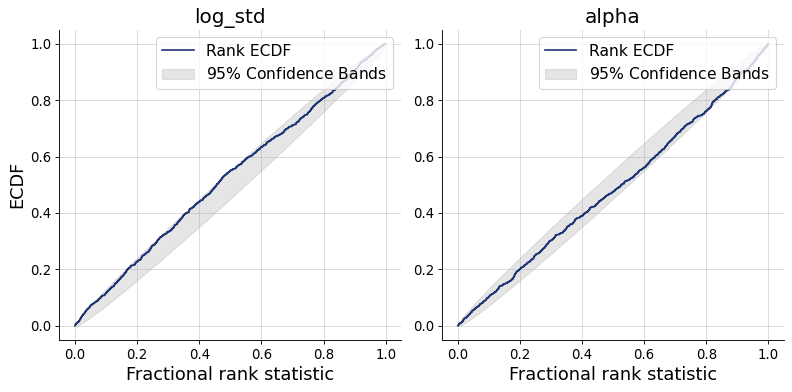

In [17]:
workflow.plot_custom_diagnostics(
    test_data=test_data,
    plot_fns={
        "recovery": bf.diagnostics.recovery,
        "calibration": bf.diagnostics.calibration_ecdf,
    },          
);